
Why Hidden Markov Models?
===============

Often in biology we have complex systems, such as the internal apparatus of an organism or an ecosystem, where we have substantial knowledge but not enough to fully describe or accurately measure the changes within.
We therefore want to reduce the system to easily understandable states that encapsulate our perceived understanding of the underlying biology. Ideally, these understandings can be inferred from easily captured data sources.

This is where the Hidden Markov models (HMM) can come in useful. Briefly, a HMM is a mathematical framework that describes a two-tiered system, where there is an observable system (the one we measure) whose changes over time can be inferred to 
represent the changes in a hidden system, one that is often more complex than the observable. We'll go into a bit more depth later about the underling principles, but a key aspect is knowing when to apply a HMM. 

Below is a simple checklist you can run through when considering a HMM for your system:


        1. Is your observable data sequential, i.e., a time series dataset or a linear structure such as protein sequences


        2. Can the underlying system (hidden states) be reasonably represented as distinct, discrete states


        3. Is it reasonable to think these hidden states are associated with our observable data


        4. Can I interpret and test the outputs to validate the model


        5. Can the system be modelled under the Markovian assumption (don't worry, we'll get to that, but it's very simple)


We'll use this as a point to introduce the system we'll be modelling throughout this tutorial: sleep in *Drosophila melanogaster*. Let's go through some background on the topic to help us answer the checklist above. Sleep has been studied in fruit flies since 2000, after sleep-like states were observed when the flies were immobile, causing a boom in studies looking to utilise all the genetic tools in fruit flies to gain a better understanding of the general theory of sleep. The flies can be housed in tubes, and their activity can be measured for many days with external inputs to change their environment. For a long time, sleep in flies was mostly considered a uniform, monostate event, something at odds with our knowledge of mammalian sleep, which has several phases. However, the gold standard for determining sleep states, EEGs, cannot be used with fruit flies due to the small size of their brains. New studies using alternative methods have shown changes in the whole brain activity throughout sleep bouts that would indicate changing sleep states. The methods are very invasive and difficult to setup, leading to the question: can we predict these internal changes from more easily accessible data?


The data we'll be working with is movement data tracked by an ethoscope, a device that can track ~20 flies at once through machine vision. You can read more about them in this [publication](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2003026).

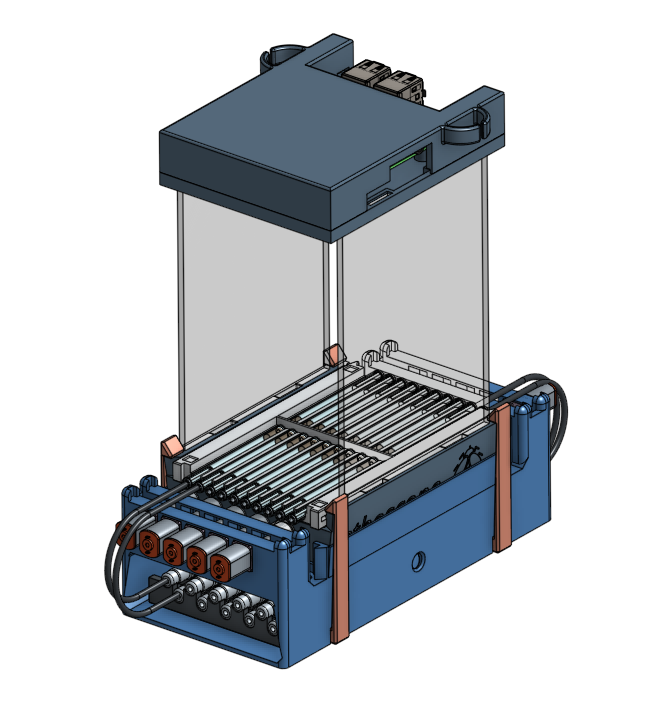
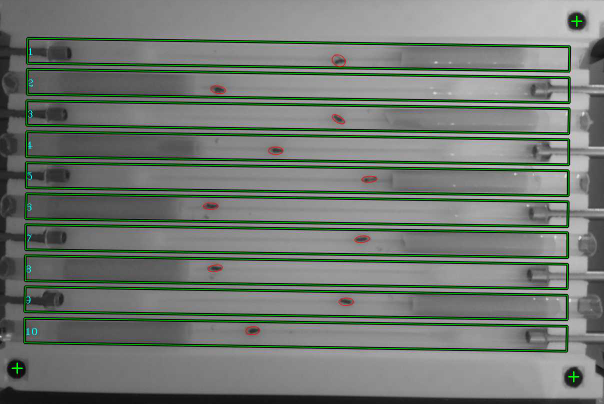

Above, in the right-hand picture, you can see the flies enclosed in red. The Ethoscope will track the flies, recording their position on a microscale. The x,y coordinates will be recorded in a database with a timestamp to give us a multivariable time series. We'll look at and get to grips with this dataset in the next notebook. But first, let's apply the system and data to the above check list.

We'll apply this to the checklist:


1. Is your observable data sequential, i.e., a time series dataset or a linear structure such as protein sequences\
        **Yes - the data is a time series tracking each individual fly across the day.**


2. Can the underlying system (hidden states) be reasonably represented as distinct, discrete states\
        **Yes - Our understanding of mammals (and birds and reptiles) is of distinct sleep states, so we can apply that to flies.**


3. Is it reasonable to think these hidden states are associated with our observable data\
        **Quite likely - most animals are immobile when sleeping with pre-sleep rituals that are driven by an internal change**


4. Can I interpret and test the outputs to validate the model\
        **Yes - Sleep is often measured by the change in arousability, so we can test the predicted states against this.**


5. Can the system be modelled under the Markovian assumption (don't worry we'll get to that, but it's very simple)\
        **We'll answer this one below.**


Now that we have passed all the checks, let's have a deeper look at Markov models to understand how to use them.

What are Hidden Markov Models
=====

HMMs are probabilistic models that work as a sequence of labelling problems, where the labelling problem is how a chain of observable events is determined by internal factors that can't be directly observed.


Both parts of a HMM, the hidden process and the observable process, are assumed to be a [stochastic processes](https://en.wikipedia.org/wiki/Stochastic_process), which are series of events that have an underlying randomness within a probabilistic space. Simply put, the data will have elements of randomness but within a known confine of outputs. For example, daily temperature can be predicted and modelled, but underlying randomness in global weather will never make the recorded data fit 1-to-1 with a model.


The hidden process is a markov chain, which is the basis for HMMs. A Markov chain (or Markovian assumption) follows the assumption that the probability of the next state in the sequence is only determined by the one you're in currently, so it's a memory-less system; none of the previous history matters, with a fixed matrix of probabilities that will infer what the next state will be.


For those of you who like mathematical equations, see below for the Markov chain rule:

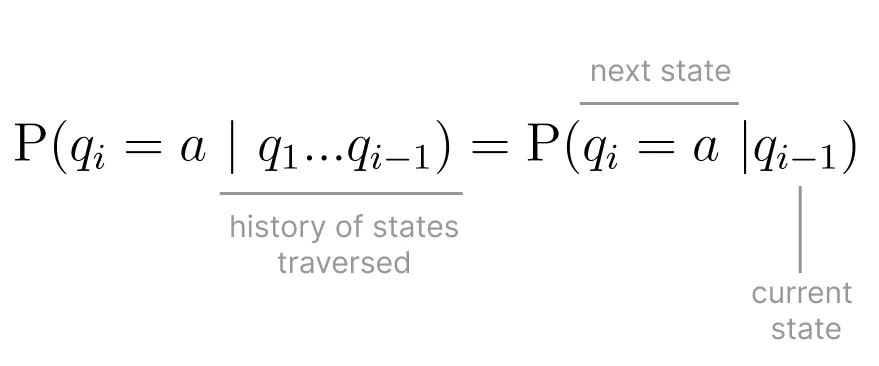

Back to our checklist briefly now we know what markov chains are:

        5. Can the system be modelled under the Markovian assumption (don't worry we'll get to that, but it's very simple)
**Most modelling is reductive, we're taking a system with thousands of interacting parts and looking at their probabilistic output. It's therefore not a definitive reflection of reality and our assumptions are the same. Applying this philosophy to the Markovian assumption we do know sleep stage transitions in mammals is determined by the previous as it changes from REM to NREM. But we also recognise it's not a memory-less process, the amount of sleep you've had previously may affect the time periods in each stages. So we'll still plough ahead with the HMM, but we will understand its limitations and use that to help us interpret the output within context**

Likewise, the observable (emission in the literature) process is also assumed to be a markov chain, it is assumed that each observed state is only dependent on the state that produced it, independent of any of the prior states, with each hidden state having a probability matrix that represents the likelihood that it will emit any given state.


Overall, you can now see that the Hidden Markov Model is quite simple, with the basis being the likelihood of states transitioning into one another and the likelihood they infer an observable state.

To sum up the parts you have:

        1. The observable process
                a. A sequence of observable states
                b. A probability emission matrix (what you train)
        
        2. The hidden process
                a. A state architecture defined by you
                b. A probability transition matrix (what you train)
        
We'll take these parts and generate representations for our example.

Breaking down the parts
=====

For this section, we'll create a scenario to help explain the components.


Let's assume students at Imperial are known to have three different states of mood: Tired, Motivated, and Happy. We ask a student to record their mood every day for a year.


We'll generate this data and look at it as a Markov chain. For this, we'll be using Numpy, a Python package for creating and manipulating data arrays. You may already be familiar with it, if not, don't fear, everything that is shown will be explained. If curious, you can head to their website for more information -> [here](https://numpy.org/doc/stable/user/quickstart.html)

In [ ]:
# For the next section we'll need to call a function saved elsewhere, to do this we need to add the folder its in to path
import sys
sys.path.append('../src/HMM')

# Now we can import any functions from the misc folder in 
from misc import create_chain
# We also need numpy for the notebook, it is commonaly imported as np to make it shorter
import numpy as np


In [ ]:
# Set the moods we want as a list
moods = ['Tired', 'Motivated', 'Happy']

# The length of the markov chain we want to produce 
l = 365

# This function will create a list of different rules from a undiclosed transition matrix
# We'll work back from the output to the transtion matrix to better understand Markov chains
mood_chain = create_chain(states = moods, start = 'Happy', length = l)

mood_chain

As you can see, the list is rather long and populated with runs of the states we provided. However, to better understand them, we'll need to change them to numbers, as they're easier to work with.

In [ ]:
# We'll want to represent our moods as numbers, so first we'll create a dictionary that show us what mood equals what number
mood_dict = {'Tired' : 0, 'Motivated' : 1, 'Happy' : 2}

# Here we use list comprehension to change each item in the list into its matched value in the dictionary
mood_array =  np.array([mood_dict[k] for k in mood_chain])

Now that we have some data, we can calculate the transition matrix for this data. The transition matrix is the likelihood that one state will transition into another; it is represented as a matrix whose shape is the number of states both across and down. So in our case, the rows will be of length 3, and there will be 3 of them. Each row must sum to 1, as it encapsulates all possibilities. See the example below:


$ Tmatrix = \left[\begin{array}{ccc}
0.1 & 0.5 & 0.4\\
0.6 & 0.2 & 0.2\\
0.3 & 0.4 & 0.3
\end{array}\right]$


We can calculate the transition matrix for a sequence by counting all the occurrences of each transition.

In [ ]:
# Don't worry too much about this function unless you want to understand it more closely
# For now it takes the array and goes through it point by point, finding the count of each transition

def transition_matrix(transitions):
    
    n = 1 + max(transitions) # the number of states, i.e 3

    M = np.zeros((n,n)) # Create an empty matrix of shape 3 x 3

    # Here it loops through the original array and one shifted to the right 1 place
    # This is give you on every loop a state and its next neighbour, for every occurance the matrix is updated with a count
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    # Now we divide by the total to get the probabilities
    M = M/M.sum(axis=1, keepdims=True)
    return M

In [ ]:
# Call the function and see the output
t_matrix = transition_matrix(mood_array)

t_matrix

We have the transition matrix for our sequence, but is it the transition probability of our system? In terms of time, a year (365 days) may seem like a long time, but in maths it's not much at all, so like how counting the flipping of a coin 100 times won't give you a 50|50 ratio of heads and tails, 365 data points is unlikely to give you the true transition matrix.


The "law of large numbers" is a principle of probability that states that the frequencies of events with the same likelihood of occurence even out, but only in instances of enough trials. Therefore, the more we increase the length, the more the transition values we get converge on the true values. As you can see, a markov chain and its transition rates are just a reflection of the likelihood that one event will happen after another; the randomness of stoachastic nature occurs as the transition rates are not 1 and therefore not guaranteed.

In [ ]:
# We'll loop through a few values and you should see the values converge
for l in [365, 5000, 10000, 100000]:
    mood_chain = create_chain(states = moods, start = 'Happy', length = l)
    mood_array =  np.array([mood_dict[k] for k in mood_chain])
    t_matrix = transition_matrix(mood_array)
    print(f'Matrix for length {l}:\n{t_matrix}\n')

You should be able to see by eye what the original transition  matrix was:

$ MoodMatrix = \left[\begin{array}{ccc}
0.70 & 0.05 & 0.25\\
0.35 & 0.50 & 0.15\\
0.05 & 0.30 & 0.65
\end{array}\right]$

Which can be better read as:

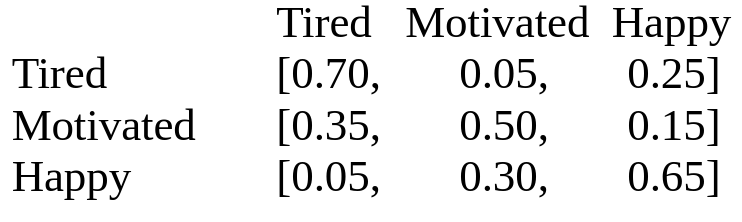

Or visually as:

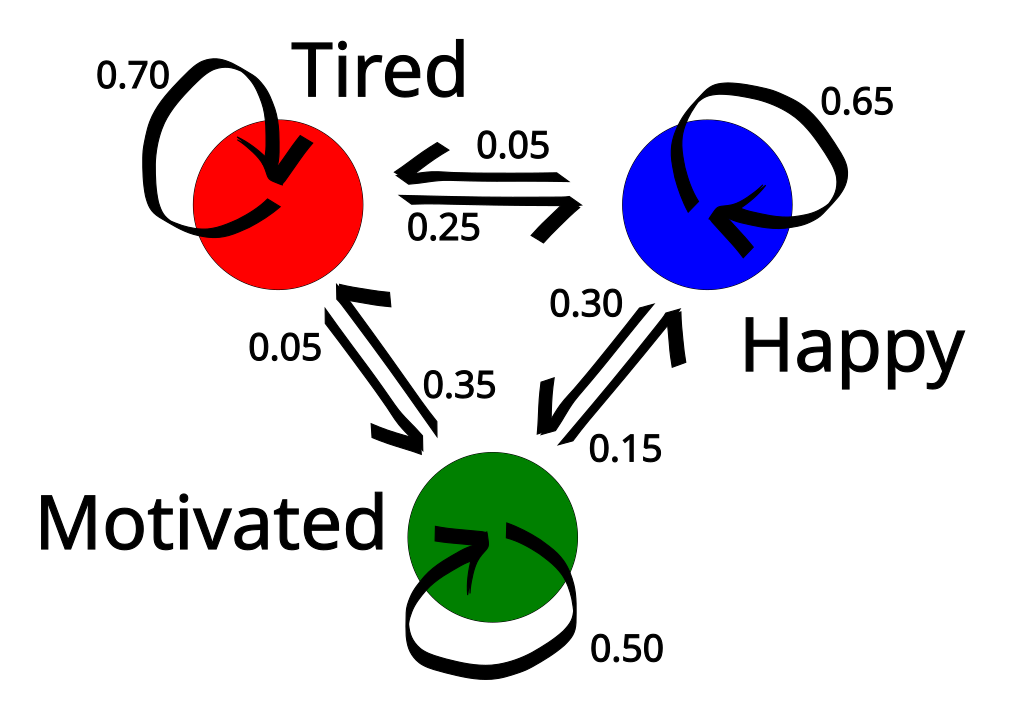

With this transition matrix we could then use it to predict the liklihood of the person being happy 5 days after they were tired, or the liklihood of 3 days of motivation in a row. However, we're not interested in the markov chain but a Hidden Markov Model, but the markov chain is what dictates our hidden states, the transition matrix we created above is the same transition matrix that will be generated in future notebooks for our example (however it won't be worked out as simply as counting the transitions).

Extra task: - Calculate what state is most likely 3 days after being Tired
            - Calculate the chance of 5 days of happiness in a row

In [ ]:
# code to calvulate 3 days after tired
start_m = np.array([1,0,0])
for i in range(3):
    start_m = start_m.dot(t_matrix)

start_m

Now lets take the mood Markov chain and pretend we can't observe them anymore, we've lost the students notes, but we do have someone observing them everyday and they note down for each day if they are mostly procrastinating all day or studying hard. This creates a time series sequence similar to what we saw before:

observable_seq = ['studying', 'styudying', 'procratinating', ...]

So we don't know what their internal state is, but we're pretty sure the observations are representative of the result of traversing the mood Markov chain. The hidden markov chain (moods) is linked to the observable sequence by a observation likelihood matrix that is similar to the tranisiton matrix, with the expection that it is the probability the observable state is to be seen given that hidden state. We call these the emissions. We can view it visually below:

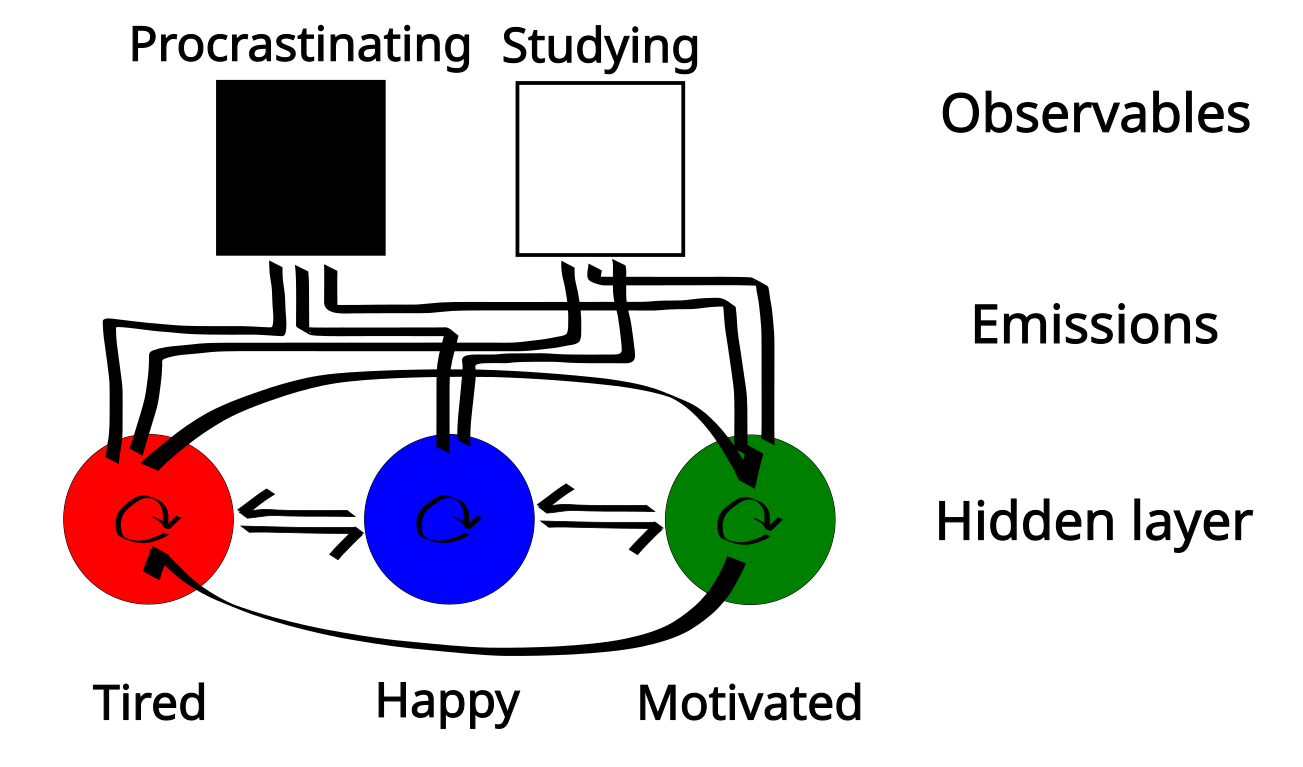

Finally, there is an intial probability distribution matrix, which is the probability that the markov chain will start in a each specific hidden state, but it is not very important for our purpose.

The intial probability matrix, the observation matrix, and the transition matrix make up the total parameters of an HMM. Once you have all of them you can decode any observable sequence from your system of interest. 

HMM algorithms
=====

We'll briefly go over two algorithms that will be used later on to train the HMM and decode the sequences. Whilst you don't need to know how they work to use the model, it can help in fully understanding the logic around the model and it's scores.

## Expectation Maximization algorithm - Training

When we approach a HMM our first problem is a training or learning problem, Where, given our observation sequence and our hidden state architecture, we want to know which parameters (the matrices we discussed above) "best" explains the relationship between the two. We therefore need to estimate these parameters, which is done by maximizing a given score against our training data (observable sequence).

To do thi, first you make an initial guess of the different matrices, usually randomised. Then the algorithm computes the probability that one hidden state follows another given the guessed transition matrix and the likely observation sequence (the expectation step), which is then compared to the true observation sequence through something called the forward-backward algorithm (the maximization step). Where a score is given that corresponds to the likelihood of that observable being seen given that hidden state, the cumulative scores per sequence  is calcuated and used to make an improved guess of the matrices.

This process is repeated many times until the score is being increased at a minimal rate, we can then say it has converged and we have aproximately found the model that is most likely to produce our given observable sequence.

## Viterbi algorithm - Decoding

When decoding an observable sequence you have a computational problem, where the brute force method would be to calculate all possible hidden state paths and then use the forward-backward alogithm to calculate the scores for each, picking the most probable path. However, this incredibly compuationally intensive. See bewlo, starting with a single state you will get an exponetional increase in the number of paths.

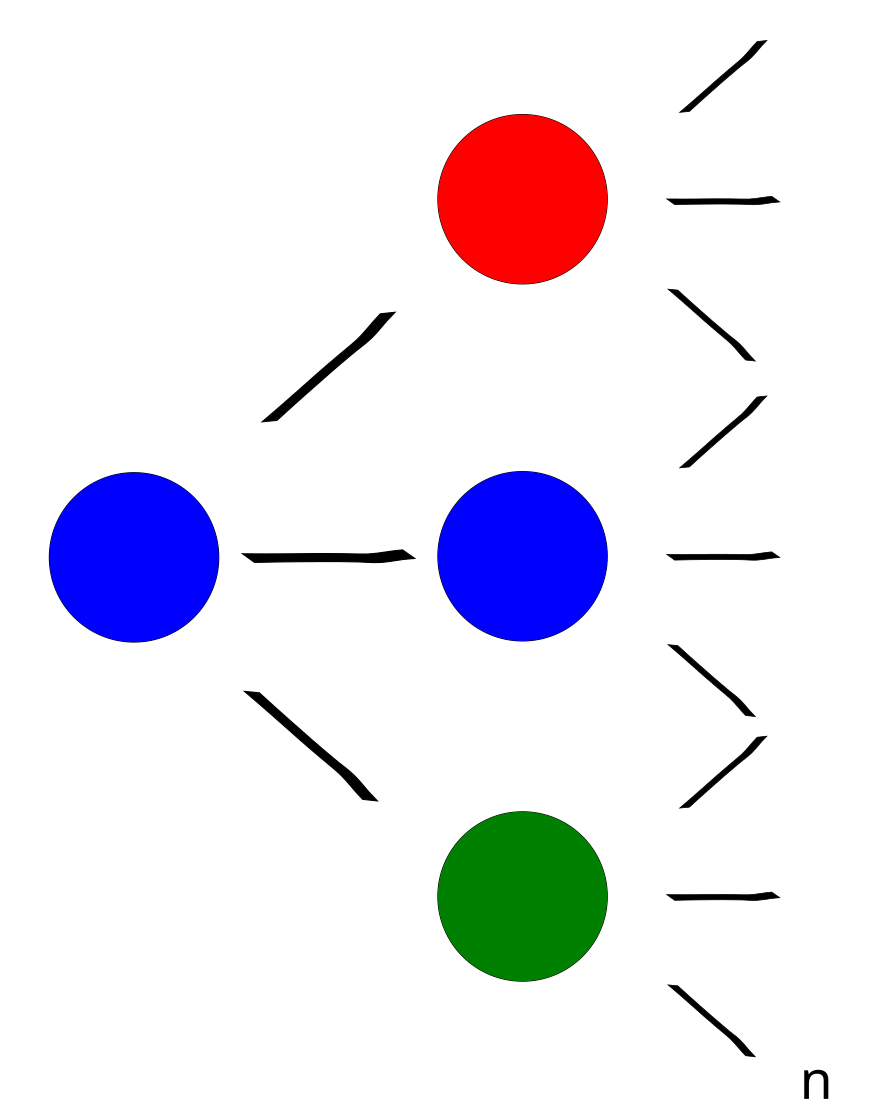

This is where the viterbi algorithm shines, the key to decoding the observation sequence is knowing there is a most probable path. The viterbi algorithm is dynamic, which means it reuses calculated results (saving time and memory). When, at time t, several paths converge then you can discard the less likely paths, and only use the most common on in the calculation. This was the number of calculations is reduced to T*N^2, whihc is a lot smaller than the exponential N^T.

Using a road map as an analogy, let's say one is trying to find the shortest path from London to Manchester. If several paths go from London to York and from York to Manchester, it doesn't make sense to join each path from London to York with each path from York to Manchester. The more natural approach is to simply find the shortest path from London to York, and then find the shortest path from York to Manchester. This saves the expense of calculating all the possible path combinations from London to Manchester, which intuitively wouldn't give you a shorter path anyway.

Now we have a decent understanding of Hidden Markov Models, we can head into the data!